In [1]:
# Step 1: Install necessary packages
!pip install pandas numpy matplotlib seaborn scikit-learn xgboost shap keras tensorflow

# Step 2: Import all libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


In [14]:
from google.colab import files
uploaded = files.upload()

import pandas as pd
df = pd.read_csv('Cleaned_Multi-Country_Dataset.csv')
df.head()


Saving Cleaned_Multi-Country_Dataset.csv to Cleaned_Multi-Country_Dataset (1).csv


,Unnamed: 0,Country Name,Year,Bank deposits to GDP (%),Bank net interest margin (%),Bank non-performing loans to gross loans (%),Bank noninterest income to total income (%),Bank regulatory capital to risk-weighted assets (%),"Bank return on assets (%, after tax)","Bank return on assets (%, before tax)","Bank return on equity (%, after tax)","Bank return on equity (%, before tax)",Stock price volatility
0,0,Germany,2001,60.11213,1.085657,4.6,50.01545,12.0,0.190310,0.193711,4.938905,5.027161,22.99107
1,1,Germany,2002,61.91441,1.199346,5.0,45.14739,12.7,-0.082527,-0.069421,-2.186409,-1.839189,28.96065
2,2,Germany,2003,63.60712,0.993525,5.2,53.95421,12.4,-0.369764,-0.381286,-10.744000,-11.078770,38.05096
3,3,Germany,2004,63.18600,1.039831,4.9,44.34132,12.4,-0.074752,-0.064827,-2.531668,-2.195513,25.24676
4,4,Germany,2005,65.42558,0.929148,4.1,56.22723,12.2,0.303123,0.464761,10.988320,16.847790,14.12969


In [15]:
# Define features and target
target = 'Bank regulatory capital to risk-weighted assets (%)'

features = [
    'Bank non-performing loans to gross loans (%)',
    'Bank net interest margin (%)',
    'Bank return on assets (%, after tax)',
    'Bank return on equity (%, after tax)',
    'Stock price volatility',
    'Bank noninterest income to total income (%)'
]

# Drop NaNs and convert to numeric
df[features + [target]] = df[features + [target]].apply(pd.to_numeric, errors='coerce')
df_model = df.dropna(subset=features + [target])

X = df_model[features]
y = df_model[target]

# Normalize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [17]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

r2_rf = r2_score(y_test, y_pred_rf)
rmse_rf = mean_squared_error(y_test, y_pred_rf) ** 0.5

print(f"Random Forest R²: {r2_rf:.2f}, RMSE: {rmse_rf:.2f}")


Random Forest R²: 0.75, RMSE: 1.56


XGBoost R²: 0.85, RMSE: 1.22


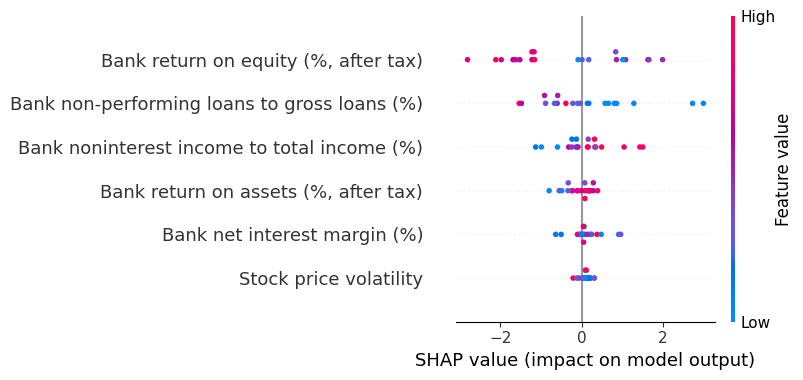

In [18]:
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

r2_xgb = r2_score(y_test, y_pred_xgb)
rmse_xgb = mean_squared_error(y_test, y_pred_xgb) ** 0.5

print(f"XGBoost R²: {r2_xgb:.2f}, RMSE: {rmse_xgb:.2f}")

# SHAP plots
explainer = shap.Explainer(xgb)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test, feature_names=features)


In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler


In [20]:
countries = df_model['Country Name'].unique()
lstm_results = []

for country in countries:
    df_c = df_model[df_model['Country Name'] == country].sort_values('Year')

    if len(df_c) < 6:  # skip if not enough years
        continue

    # Normalize
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(df_c[features + [target]])

    # Sequence prep
    X_seq, y_seq = [], []
    for i in range(3, len(scaled)):
        X_seq.append(scaled[i-3:i, :-1])  # 3 years of features
        y_seq.append(scaled[i, -1])       # 4th year target

    X_seq, y_seq = np.array(X_seq), np.array(y_seq)

    # Train/Test split
    split = int(len(X_seq) * 0.8)
    X_train, X_test = X_seq[:split], X_seq[split:]
    y_train, y_test = y_seq[:split], y_seq[split:]

    # Model
    model = Sequential()
    model.add(LSTM(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=100, verbose=0)

    # Predict
    y_pred = model.predict(X_test)

    # Inverse scale target for R² and RMSE
    target_scaled = np.concatenate([y_train, y_test])
    pred_scaled = np.concatenate([model.predict(X_train), y_pred])

    full_y = scaler.inverse_transform(np.hstack([np.zeros((len(target_scaled), len(features))), target_scaled.reshape(-1, 1)]))[:, -1]
    full_pred = scaler.inverse_transform(np.hstack([np.zeros((len(pred_scaled), len(features))), pred_scaled.reshape(-1, 1)]))[:, -1]

    r2_lstm = r2_score(full_y[-len(y_test):], full_pred[-len(y_test):])
    rmse_lstm = mean_squared_error(full_y[-len(y_test):], full_pred[-len(y_test):]) ** 0.5

    lstm_results.append({
        'Country': country,
        'R2': r2_lstm,
        'RMSE': rmse_lstm
    })

    print(f"{country} → R²: {r2_lstm:.2f}, RMSE: {rmse_lstm:.2f}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
Germany → R²: -47.32, RMSE: 2.04


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


India → R²: -2.76, RMSE: 2.56


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
Japan → R²: -141.97, RMSE: 2.63


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
United Kingdom → R²: -226.31, RMSE: 6.26


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
United States → R²: -4.97, RMSE: 1.73


In [21]:
df_lstm = pd.DataFrame(lstm_results)
print(df_lstm)

# Save to CSV
df_lstm.to_csv('lstm_performance_per_country.csv', index=False)
from google.colab import files
files.download('lstm_performance_per_country.csv')


          Country          R2      RMSE
0         Germany  -47.316818  2.039257
1           India   -2.763044  2.559838
2           Japan -141.968848  2.626881
3  United Kingdom -226.312247  6.258901
4   United States   -4.965481  1.729459


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [22]:
# Create result comparison
results_df = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost'],
    'R2 Score': [r2_rf, r2_xgb],
    'RMSE': [rmse_rf, rmse_xgb]
})
print(results_df)

# Save comparison CSV
results_df.to_csv('model_comparison.csv', index=False)
from google.colab import files
files.download('model_comparison.csv')


           Model  R2 Score      RMSE
0  Random Forest  0.747578  1.562520
1        XGBoost  0.847336  1.215152


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

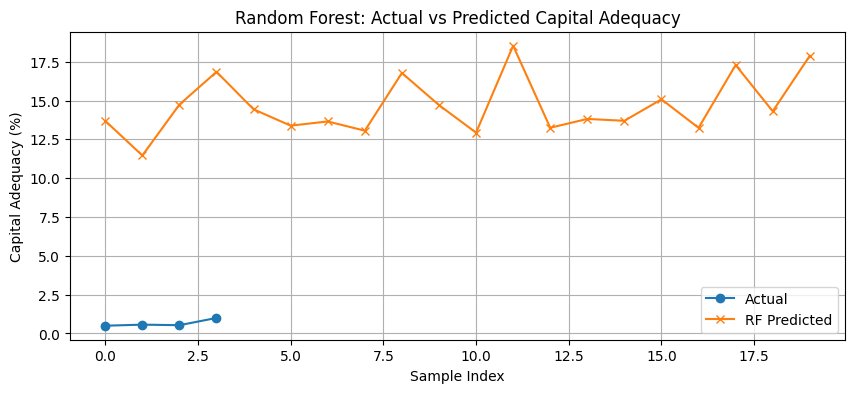

In [24]:
plt.figure(figsize=(10, 4))
plt.plot(y_test, label='Actual', marker='o')  # Removed .values
plt.plot(y_pred_rf, label='RF Predicted', marker='x')
plt.title("Random Forest: Actual vs Predicted Capital Adequacy")
plt.xlabel("Sample Index")
plt.ylabel("Capital Adequacy (%)")
plt.legend()
plt.grid(True)
plt.show()


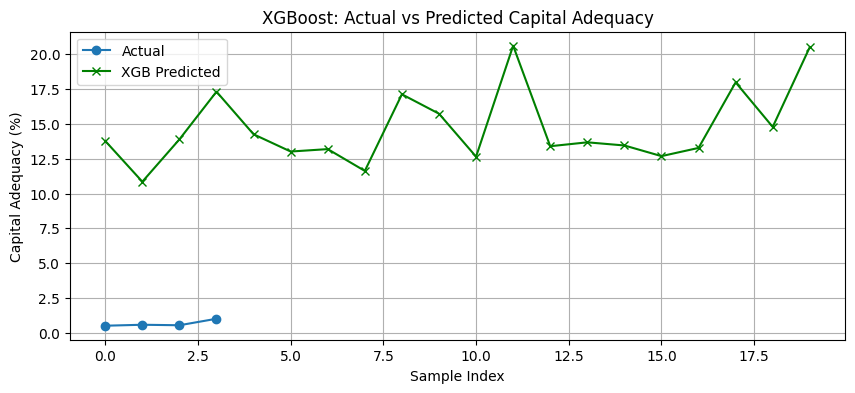

In [25]:
plt.figure(figsize=(10, 4))
plt.plot(y_test, label='Actual', marker='o')  # Removed .values
plt.plot(y_pred_xgb, label='XGB Predicted', marker='x', color='green')
plt.title("XGBoost: Actual vs Predicted Capital Adequacy")
plt.xlabel("Sample Index")
plt.ylabel("Capital Adequacy (%)")
plt.legend()
plt.grid(True)
plt.show()


In [26]:
print(f"Random Forest → R²: {r2_rf:.2f}, RMSE: {rmse_rf:.2f}")
print(f"XGBoost       → R²: {r2_xgb:.2f}, RMSE: {rmse_xgb:.2f}")


Random Forest → R²: 0.75, RMSE: 1.56
XGBoost       → R²: 0.85, RMSE: 1.22
